In [ ]:
%pip install docusign-esign

In [ ]:
import docusign_esign as docusign

# Criando sua Conta de Desenvolvedor

https://developers.docusign.com/

### Criando aplicação para conectar-se com a API

Logo após a criação da conta de desenvolvedor, acessamos o seguinte link:

https://admindemo.docusign.com/apps-and-keys

In [ ]:
user_id = '' # Adicione o seu ID de usuario

### Crie uma nova aplicação

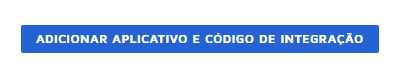

In [ ]:
integration_key = ''  # Salve aqui sua Chave de Integração
secret_key      = ''  # Salve aqui sua Chave Secreta

### Gerar RSA

Copie e cole suas chaves em bloco de notas distintos no mesmo diretório do Notebook ( privatekey.txt e publickey.txt )

Você só conseguirá consultar essas chaves na criação. Portanto, **não esqueça de salvá-las!**

### Adicionar URI

Adicione no campo a seguir, a url:   *http://<span></span>localhost*

Clique em **Salvar**.

In [ ]:
with open('privatekey.txt', 'r') as pk:
    private_key = pk.read()
print(private_key)

### Liberar consentimento para a aplicação

Após seguir todos os passos anteriores, precisaremos liberar o consentimento para sua aplicação ara sua aplicação ser executada livremente.

#### Adapte o link a seguir com os seus dados obtidos e rode ele no navegador.

https://<span></span>account-d.docusign.com/oauth/auth?response_type=code&scope=signature%20impersonation&client_id=*YOUR_INTEGRATOR_KEY*&redirect_uri=*YOUR_REDIRECT_URI*


Irá retornar um erro, mas faz parte do processo!
<br><br>

# Conectando-se à API

Saiba mais sobre os tipos de [**Autenticação**](https://developers.docusign.com/docs/esign-rest-api/esign101/auth/).

In [ ]:
authorization_server = 'account-d.docusign.com'
base_path = 'https://demo.docusign.net/restapi'

api_client = docusign.ApiClient(host=base_path, oauth_host_name=authorization_server, base_path=base_path)

# Getting Token
token = api_client.request_jwt_user_token(
    client_id=integration_key, 
    user_id=user_id, 
    oauth_host_name=authorization_server, 
    private_key_bytes=private_key, 
    expires_in=3600, 
    scopes=['signature', 'impersonation'])
access_token = token.access_token

user_info = api_client.get_user_info(access_token)

In [ ]:
#user_info.__dict__

In [ ]:
# Getting Account Id
account_id = user_info.accounts[0].account_id

# Criando e enviando um Envelope

Um envelope no Docusign é estruturado da seguinte maneira:

* Um ou mais documentos que serão assinados eletronicamente
* Informação sobre o remetente
* Informações sobre os destinatários, incluindo todos os outros objetos (como guias) que estão associados a esses destinatários
* Informações de status que rastreiam a entrega e o andamento da assinatura

O diagrama de envelope mostra a estrutura de dados de um objeto de envelope, ilustrando como ele contém documentos e destinatários de vários tipos, bem como as guias associadas a esses destinatários.

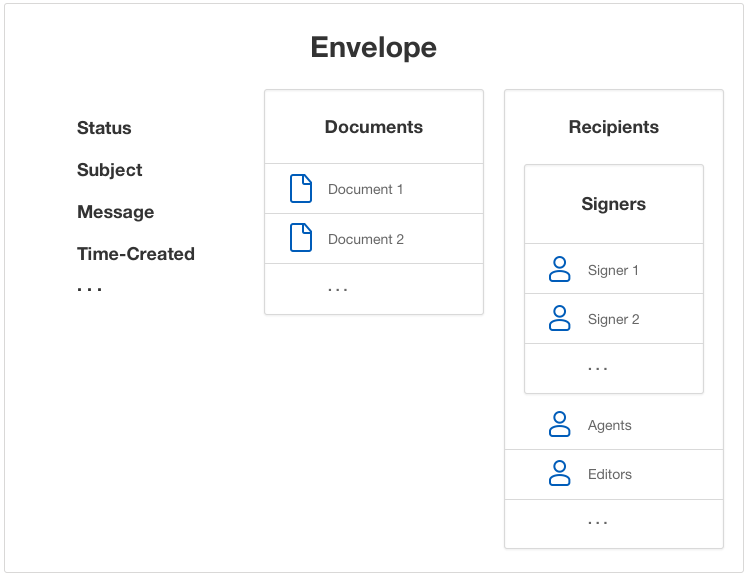

Para mais informações sobre [**envelope**](https://developers.docusign.com/docs/esign-rest-api/esign101/concepts/envelopes/) e [**recipientes**](https://developers.docusign.com/docs/esign-rest-api/esign101/concepts/recipients/)

Sendo assim, nossos primeiros passos são a criação do *Documento* e dos *Recipientes*

## Documento

Um [**documento**](https://developers.docusign.com/docs/esign-rest-api/esign101/concepts/documents/) é um objeto que contém um arquivo de documento digital e um conjunto de metadados que descreve esse arquivo de documento. Um arquivo de documento contém conteúdo a ser revisado ou assinado por um ou mais destinatários.

Formatos aceitos: PDF, DOCX, RTF, TXT, e PNG

In [ ]:
import base64

In [ ]:
with open('documento.pdf', 'rb') as sign_file:
    file_contents = sign_file.read()

In [ ]:
base64_doc = base64.b64encode(file_contents).decode("utf-8")
name = 'TestFile.pdf'
document_id = '1'
doc = docusign.Document(document_base64=base64_doc,
                        name=name,
                        document_id=document_id)
documents = [doc]

## Recipients (destinatários)

Para cada assinante, devemos estipular seus respectivos locais de assinaturas. Chamamos isso de [**Tabs**](https://developers.docusign.com/docs/esign-rest-api/esign101/concepts/tabs/), e para isso, usamos o módulo SignHere da API

Calculando a [**Posição**](https://developers.docusign.com/docs/esign-rest-api/esign101/concepts/tabs/fixed/)

In [ ]:
tab = docusign.SignHere(document_id  = '1',
                        page_number  = 1,
                        recipient_id = '1',
                        x_position   = '275',
                        y_position   = '465',
                        scale_value  = 1)

In [ ]:
email = 'gustavorambaldi93@gmail.com'
name = 'Gustavo Rambaldi'
signer = docusign.Signer(email=email,
                         name=name,
                         recipient_id='2',
                         routing_order='2',
                         tabs=docusign.Tabs(sign_here_tabs=[tab]))

In [ ]:
email = 'gustavo.magalhaes@agnet.com.br'
name = 'Gustavo AG'
reviewer = docusign.CertifiedDelivery(email=email,
                                     name=name,
                                     recipient_id='1',
                                     routing_order='1')

In [ ]:
recipients = docusign.Recipients(signers=[signer], certified_deliveries=[reviewer])

In [ ]:
envelopes_api = docusign.EnvelopesApi(api_client)

## Definindo e enviando o Envelope

In [ ]:
email_subject = 'Assinatura bacana requisitada'
email_blurb = 'Hello World das assinaturas!'

In [ ]:
# Definindo o Envelope
status = 'sent'
envelope_definition = docusign.EnvelopeDefinition(email_subject=email_subject,
                                                  email_blurb=email_blurb,
                                                  documents=documents,
                                                  recipients=recipients,
                                                  status=status)

In [ ]:
# Enviando o Envelope
envelope_summary = envelopes_api.create_envelope(account_id, envelope_definition=envelope_definition)

In [ ]:
envelope_summary

In [ ]:
envelope_id = envelope_summary.envelope_id
envelopes_api.get_envelope(account_id, envelope_id)

## Template

Um [**Template**](https://developers.docusign.com/docs/esign-rest-api/esign101/concepts/templates/) é um objeto que contém uma definição de envelope e pode ser usado como um projeto para criar um ou mais envelopes usando suas informações armazenadas. Os templates agilizam o processo de envio quando você envia com frequência documentos iguais ou semelhantes, ou envia documentos diferentes para o mesmo grupo de pessoas.

* *Os templates contêm informações do envelope, mas você não pode enviar templates como se fossem envelopes. Em vez disso, você pode criar envelopes usando um ou mais modelos para preencher previamente o envelope com as informações dos modelos escolhidos.*


* *Os templates não definem destinatários específicos. Em vez disso, eles definem funções genéricas que representam as partes envolvidas na transação do envelope. Ao criar um envelope a partir de um template, você especifica destinatários específicos para cada função definida no template.*

In [ ]:
# Definindo e-mail
email_subject = 'Assinatura obrigatória'
email_blurb = 'Assine ou será um foragido!'

# Documento
with open('documento_template.pdf', 'rb') as sign_file:
    file_contents = sign_file.read()
base64_doc = base64.b64encode(file_contents).decode("utf-8")
doc = docusign.Document(document_base64 = base64_doc,
                        name = 'Documento Template.pdf',
                        document_id = '1')
documents = [doc]


tab = docusign.SignHere(document_id  = '1',
                        page_number  = 1,
                        recipient_id = '1',
                        x_position   = '275',
                        y_position   = '710',
                        scale_value  = '1')

email = 'gustavorambaldi93@gmail.com'
name = 'Gustavo'
signer = docusign.Signer(email=email,
                         name=name,
                         recipient_id='1',
                         tabs=docusign.Tabs(sign_here_tabs=[tab]))

recipients = docusign.Recipients(signers=[signer])

In [ ]:
# Definindo o Template
template_name = 'myTemplate'
envelope_template = docusign.EnvelopeTemplate(email_subject=email_subject,
                                              email_blurb=email_blurb,
                                              documents=documents,
                                              recipients=recipients,
                                              name=template_name)

In [ ]:
# Criando Template
templates_api = docusign.TemplatesApi(api_client)
template_summary = templates_api.create_template(account_id, envelope_template=envelope_template)

In [ ]:
template_summary

Adquirindo o Template Id do nosso template

In [ ]:
template_id = template_summary.template_id

In [ ]:
tab = docusign.SignHere(document_id  = '1',
                        page_number  = 1,
                        recipient_id = '2',
                        x_position   = '275',
                        y_position   = '710',
                        scale_value  = '1')

email = 'adalberto@gmail.com'
name = 'Adalberto'
signer = docusign.Signer(email=email,
                         name=name,
                         recipient_id='2',
                         tabs=docusign.Tabs(sign_here_tabs=[tab]))

recipients2 = docusign.Recipients(signers=[signer])

In [ ]:
templates_api.create_recipients(account_id, template_id, template_recipients=recipients)

In [ ]:
status = 'sent'
envelope_definition_template = docusign.EnvelopeDefinition(email_subject=email_subject,
                                                           email_blurb=email_blurb,
                                                           template_id=template_id,
                                                           status=status)

Repetindo o passo anterior para criação e envio do envelope

In [ ]:
# Enviando o Envelope
envelope_summary_template = envelopes_api.create_envelope(account_id, envelope_definition=envelope_definition_template)

In [ ]:
envelope_summary_template

# Lista de Template

In [ ]:
list_templates = templates_api.list_templates(account_id).envelope_templates

for template in list_templates:
    print('Nome    : ', template.name)
    print('Assunto : ', template.email_subject)
    print('Corpo   : ', template.email_blurb, '\n')

#### Clique [AQUI](https://blog.idwall.co/o-que-e-uma-api-e-quais-seus-beneficios/?utm_term=&utm_campaign=Google_Search_Perf-conv_Nacional_Blog_DSA&utm_source=adwords&utm_medium=ppc&hsa_acc=4544575733&hsa_cam=14824085929&hsa_grp=128729978878&hsa_ad=549134874171&hsa_src=g&hsa_tgt=dsa-41848713900&hsa_kw=&hsa_mt=&hsa_net=adwords&hsa_ver=3&gclid=CjwKCAiAz--OBhBIEiwAG1rIOqJKGbmaWQnAWuTOadtQN0MSE4Amu_vcbl0nWYqMFXV6lZexPw1t-RoCfdQQAvD_BwE) para saber mais sobre APIs e suas vantagens.



[**Testes Unitários**](https://github.com/docusign/docusign-esign-python-client/blob/master/test/unit_tests.py)

# Exercícios

**1)** Descubra o status da assinatura e o id do destinatário cadastrado anteriormente. O documento já foi visualizado pelo menos?

**2)** Crie um envelope usando o arquivo ( exercicio.pdf ) e envie para 2 destinatários distíntos.

In [ ]:
def new_tab(document_id, recipient_id, page):
    position = {
        '1' : {'page': '1', 'x' : '275', 'y': '450'},  # recipient_id 1
        '2' : {'page': '1', 'x' : '275', 'y': '500'},  # recipient_id 2
    }
    return docusign.SignHere(document_id  = document_id,
                             page_number  = position[recipient_id]['page'],
                             recipient_id = recipient_id,
                             x_position   = position[recipient_id]['x'],
                             y_position   = position[recipient_id]['y'],
                             scale_value  = '1')

In [ ]:
def new_signer(document_id, email, name, recipient_id):
    tabs = [new_tab(document_id, recipient_id, 1)]
    return docusign.Signer(email=email,
                           name=name,
                           recipient_id=recipient_id,
                           tabs=docusign.Tabs(sign_here_tabs=tabs))